[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/boostcourse-ds-511/blob/master/pima-classification-baseline-01.ipynb)


* 강좌 보기 : https://www.edwith.org/boostcourse-ds-511

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6f/Pima.jpg" width=200>

* [Pima people - Wikipedia](https://en.wikipedia.org/wiki/Pima_people)
* 미국의 피마 인디언에게서 서구화로 인한 당뇨병 발병

## 데이터셋 출처
* [Pima Indians Diabetes Database | Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database)
    * 데이터의 개수가 더 많음
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html


### 데이터 구성

* Pregnancies : 임신 횟수
* Glucose : 2시간 동안의 경구 포도당 내성 검사에서 혈장 포도당 농도 
* BloodPressure : 이완기 혈압 (mm Hg)
* SkinThickness : 삼두근 피부 주름 두께 (mm), 체지방을 추정하는데 사용되는 값
* Insulin : 2시간 혈청 인슐린 (mu U / ml)
* BMI : 체질량 지수 (체중kg / 키(m)^2)
* DiabetesPedigreeFunction : 당뇨병 혈통 기능
* Age : 나이
* Outcome : 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0입니다.
    * 예측해야 할 데이터

## EDA 결과
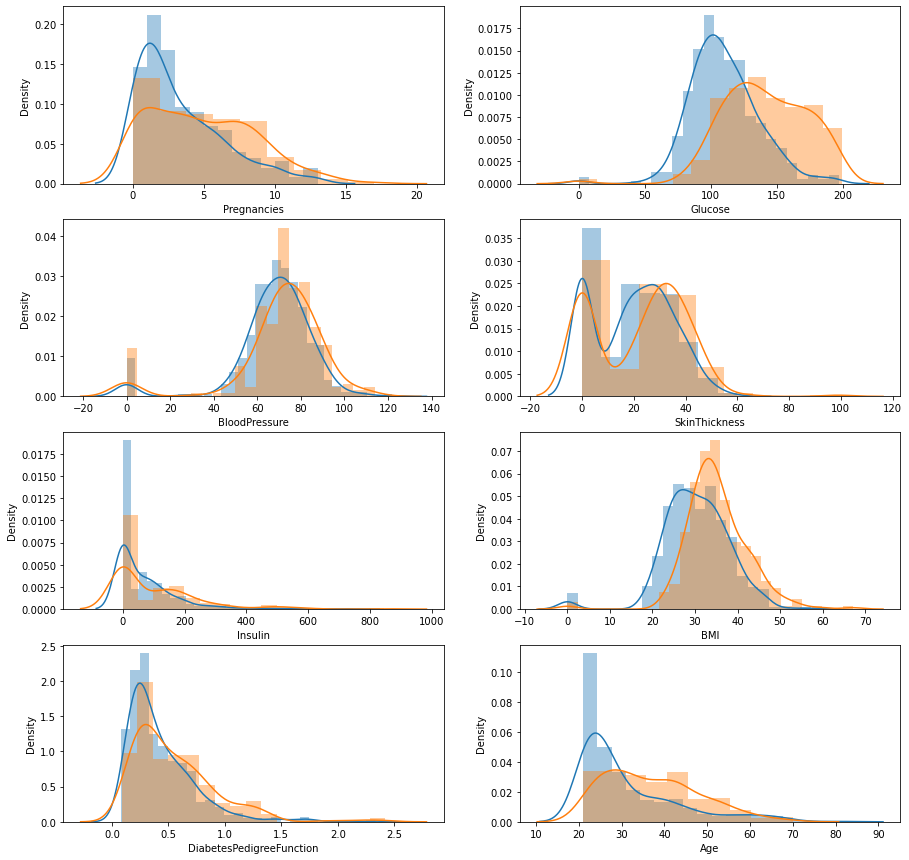

* 조건을 일반화해야 한다.
    * Pregnancies 횟수는 20회에 가까워질수록 수 많지 않기 때문에 일반화하기 어렵다.
    * Age는 30세, 60세를 전후로 당뇨병 발병 여부에 차이가 있다.
    * 수치형 데이터 몇 가지를 범주형으로 만든다.(Pregnancies, Glucose, BMI, Age 등)

## 필요한 라이브러리 로드

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy
# 시각화를 위한 seaborn, matplotlib.pyplot 을 로드합니다. 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 데이터셋 로드

In [2]:
df = pd.read_csv("data/diabetes.csv")
df.shape

(768, 9)

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Feature Engineering

### 수치형 변수를 범주형 변수로 만들기
* Pregnancies 값이 6보다 큰 경우와 그렇지 않은 경우로 구분한다.
* Age를 25세 미만, 25세 이상 60세 이하, 60세 초과로 구분한다.

In [4]:
df["Pregnancies_high"] = df["Pregnancies"] > 6
df[["Pregnancies", "Pregnancies_high"]]

,Pregnancies,Pregnancies_high
0,6,False
1,1,False
2,8,True
3,1,False
4,0,False
...,...,...
763,10,True
764,2,False
765,5,False
766,1,False


In [6]:
# One-Hot-Encodng
df["Age_low"] = df["Age"] < 25
df["Age_middle"] = (df["Age"] >= 25) & (df["Age"] <= 60)
df["Age_high"] = df["Age"] > 60
df[["Age", "Age_low", "Age_middle", "Age_high"]]

,Age,Age_low,Age_middle,Age_high
0,50,False,True,False
1,31,False,True,False
2,32,False,True,False
3,21,True,False,False
4,33,False,True,False
...,...,...,...,...
763,63,False,False,True
764,27,False,True,False
765,30,False,True,False
766,47,False,True,False


<AxesSubplot:xlabel='Age_high', ylabel='count'>

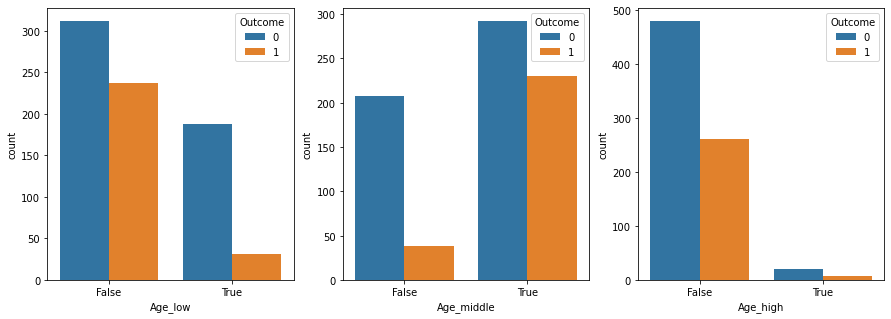

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.countplot(data=df, x="Age_low", hue="Outcome", ax=axes[0])
sns.countplot(data=df, x="Age_middle", hue="Outcome", ax=axes[1])
sns.countplot(data=df, x="Age_high", hue="Outcome", ax=axes[2])

## 학습, 예측 데이터셋 나누기

In [21]:
# 8:2 의 비율로 구하기 위해 전체 데이터의 행에서 80% 위치에 해당되는 값을 구해서 split_count 라는 변수에 담습니다.
split_count = int(df.shape[0] * 0.8)
split_count

614

In [22]:
# train, test로 슬라이싱을 통해 데이터를 나눕니다.
train = df[:split_count].copy()
train.shape

(614, 13)

In [23]:
test = df[split_count:].copy()
test.shape

(154, 13)

## 학습, 예측에 사용할 컬럼

In [24]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.
feature_names = train.columns.tolist()
feature_names.remove("Pregnancies")
feature_names.remove("Age")
feature_names.remove("Outcome")
feature_names

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Pregnancies_high',
 'Age_low',
 'Age_middle',
 'Age_high']

## 정답값이자 예측해야 될 값

In [25]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.
label_name = "Outcome"
label_name

'Outcome'

## 학습, 예측 데이터셋 만들기

In [26]:
# 학습 세트 만들기 예) 시험의 기출문제
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(614, 10)


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Pregnancies_high,Age_low,Age_middle,Age_high
0,148,72,35,0,33.6,0.627,False,False,True,False
1,85,66,29,0,26.6,0.351,False,False,True,False
2,183,64,0,0,23.3,0.672,True,False,True,False
3,89,66,23,94,28.1,0.167,False,True,False,False
4,137,40,35,168,43.1,2.288,False,False,True,False


In [27]:
# 정답 값을 만들어 줍니다. 예) 기출문제의 정답
y_train = train[label_name]
print(y_train.shape)
y_train.head()

(614,)


0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [28]:
# 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(154, 10)


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Pregnancies_high,Age_low,Age_middle,Age_high
614,138,74,26,144,36.1,0.557,True,False,True,False
615,106,72,0,0,25.8,0.207,False,False,True,False
616,117,96,0,0,28.7,0.157,False,False,True,False
617,68,62,13,15,20.1,0.257,False,True,False,False
618,112,82,24,0,28.2,1.282,True,False,True,False


In [29]:
# 예측의 정답값 예) 실전 시험 문제의 정답
y_test = test[label_name]
print(y_test.shape)
y_test.head()

(154,)


614    1
615    0
616    0
617    0
618    1
Name: Outcome, dtype: int64

## 머신러닝 알고리즘 가져오기

In [30]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model

DecisionTreeClassifier()

## 학습(훈련)
* 시험을 볼 때 기출문제(X_train)와 정답(y_train)을 보고 공부하는 과정과 유사합니다.

In [31]:
model.fit(X=X_train, y=y_train)

DecisionTreeClassifier()

## 예측
* 실전 시험문제(X_test)라고 보면 됩니다. 우리가 정답을 직접 예측합니다.

In [32]:
y_predict = model.predict(X_test)
y_predict[:5]

array([1, 0, 0, 0, 1], dtype=int64)

## 트리 알고리즘 분석하기
* 의사결정나무를 시각화 합니다.

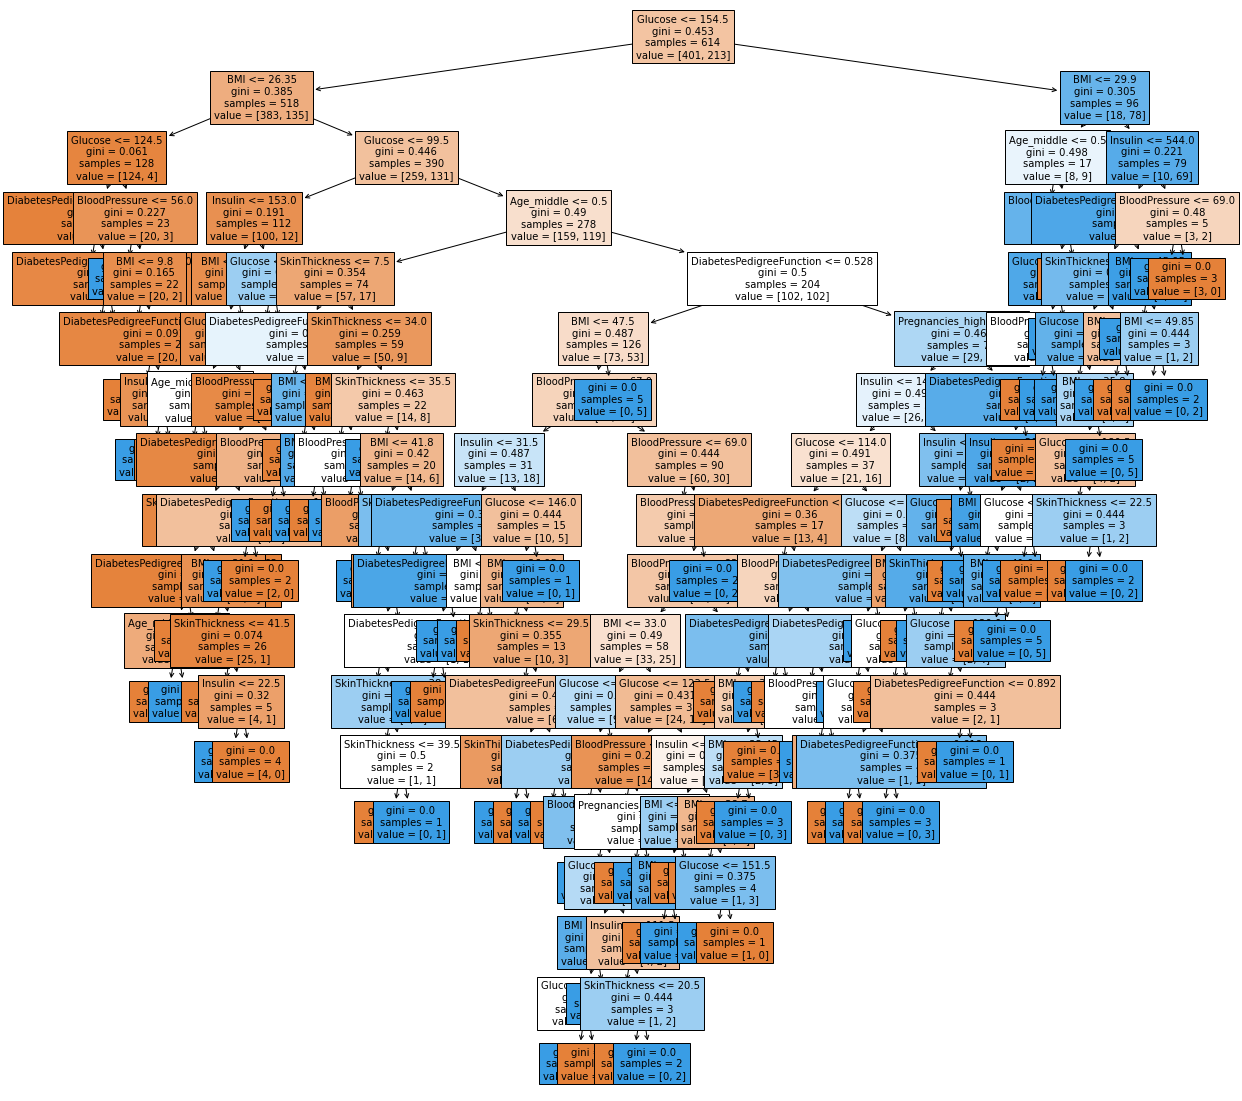

In [33]:
# gini계수가 0이 되면 트리를 그리기를 멈추고 당뇨병 여부를 판단
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
tree = plot_tree(model,
                 feature_names=feature_names,
                 filled=True,
                 fontsize=10)

In [34]:
# graphviz 를 통해 시각화 합니다.
# graphviz 는 별도의 설치가 필요합니다. 
# graphviz 와 파이썬에서 graphviz 를 사용할 수 있게 해주는 도구 2가지를 설치해 주셔야 합니다.
# import graphviz
# from sklearn.tree import export_graphviz

# dot_tree = export_graphviz(model,
#                            feature_names = feature_names,
#                            filled=True)
# graphviz.Source(dot_tree)

In [35]:
# 피처의 중요도를 추출하기
model.feature_importances_

array([0.33332455, 0.09709141, 0.07345497, 0.07921555, 0.23258608,
       0.10515251, 0.01939821, 0.        , 0.05977672, 0.        ])

<AxesSubplot:>

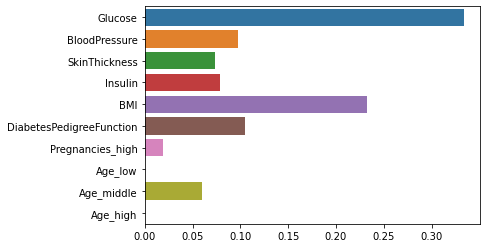

In [36]:
# 피처의 중요도 시각화 하기
sns.barplot(x=model.feature_importances_, y=feature_names)

* 이전에는 Pregnancies가 꽤 중요한 역할을 했으나, Pregnancies_high는 그다지 중요한 역할을 하지 않는 것으로 보인다.
* Age_low나 Age_high는 모수가 작아서인지 그다지 중요한 역할을 하지 않는다.

## 정확도(Accuracy) 측정하기

In [37]:
# 실제값 - 예측값을 빼주면 같은 값은 0으로 나오게 됩니다. 
# 여기에서 절대값을 씌운 값이 1인 값이 다르게 예측한 값이 됩니다.
# 합하면 다르게 예측한 값의 개수
diff_count = abs(y_test - y_predict).sum()
diff_count

48

* 38 => 37(임신횟수) => 48(나이)

In [38]:
# 예측의 정확도를 구합니다. 100점 만점 중에 몇 점을 맞았는지 구한다고 보면 됩니다.
(len(y_test) - diff_count) / len(y_test) * 100

68.83116883116884

In [39]:
# 위에서 처럼 직접 구할 수도 있지만 미리 구현된 알고리즘을 가져와 사용합니다.
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict) * 100

68.83116883116884

In [40]:
# model 의 score 로 점수를 계산합니다.
model.score(X_test, y_test) * 100

68.83116883116884